In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

データセット説明  
このコンペティションでは、エクアドルにあるFavoritaの店舗で販売されている数千の商品群の売上を予測します。学習データには、日付、店舗、商品情報、その商品が宣伝されていたかどうか、そして販売数が含まれています。追加ファイルには、モデルを構築する際に有用と思われる補足情報が含まれています。
  
ファイルの説明とデータフィールド情報

train.csv  
学習データ。store_nbr, family, onpromotionの時系列データと対象売上から構成される。  
store_nbrは商品が販売されている店舗を特定する。  
family は、販売されている商品の種類を特定する。  
salesは、ある日付のある店舗での、ある製品ファミリーの総売上を示す。製品は端数単位で販売されることがあるため、端数の値も可能です (たとえば、1袋のチップスではなく、1.5 kgのチーズなど)。  
onpromotion は、ある日付の店舗でプロモーションが行われた商品群の総数を示します。  

test.csv  
学習データと同じ特徴量を持つテストデータです。このファイル内の日付の目標売上を予測することになります。  
テストデータの日付は、トレーニングデータの最後の日付から15日後のものです。   

sample_submission.csv
正しいフォーマットのサンプル投稿ファイルです。  

stores.csv  
都市、州、タイプ、クラスタなどの店舗のメタデータ。  
clusterは、類似した店舗のグループ化です。  

oil.csv  
毎日の原油価格。訓練データとテストデータの時間枠の両方の値を含む。(エクアドルは石油に依存する国であり、石油価格の変動に対して非常に脆弱な経済状態である)  

holidays_events.csv 
祝日とイベント（メタデータ付き  
注：転送された列には特に注意してください。転送された祝日は、公式にはそのカレンダー上の日に当たりますが、政府によって別の日に移動させられたものです。転送された日は、休日というより通常の日に近いです。実際に祝われた日を見つけるには、TypeがTransferになっている該当の行を探します。例えば、Independencia de Guayaquilは2012-10-09から2012-10-12に移され、2012-10-12に祝われました。タイプがブリッジの日は、祝日に追加される余分な日です（例えば、長い週末をまたいで休みを延長するため）。これらは頻繁にタイプWork Dayによって補われます。これは、通常仕事の予定がない日（例：土曜日）で、Bridgeを返済するためのものです。  
追加の休日とは、例えば、一般的にクリスマス前後に起こるように、通常のカレンダー上の休日を追加した日です（クリスマスイブを休日とする）。  

その他の注意事項  
公共部門の賃金は、2週間ごとに15日と月末に支払われます。スーパーマーケットの売上に影響が出る可能性があります。  
2016年4月16日、エクアドルでマグニチュード7.8の地震が発生しました。地震発生後数週間はスーパーマーケットの売上に大きな影響を与えたため、人々は水やその他の生活必需品を寄付する救援活動を行いました。  

In [36]:
Store_data = pd.read_csv('../input/stores.csv')
Train_data = pd.read_csv('../input/train.csv')
Oil_data = pd.read_csv('../input/oil.csv') 
Holidays_data = pd.read_csv('../input/holidays_events.csv') 
Transactions_data = pd.read_csv('../input/transactions.csv')

In [37]:
Store_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [38]:
Oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [39]:
Holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [40]:
Transactions_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [7]:
Train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [41]:
df = Train_data.merge(Store_data, on='store_nbr', how='left')

In [42]:
df = df.merge(Oil_data, on='date', how='left')
df = df.merge(Holidays_data, on='date', how='left')
df = df.merge(Transactions_data, on=['date', 'store_nbr'], how='left')

In [43]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   city          object 
 7   state         object 
 8   type_x        object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  type_y        object 
 12  locale        object 
 13  locale_name   object 
 14  description   object 
 15  transferred   object 
 16  transactions  float64
dtypes: float64(3), int64(4), object(10)
memory usage: 419.5+ MB


In [46]:
df['date'] = pd.to_datetime(df['date'])

In [48]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [ ]:
df_sale_store_type = df.groupby

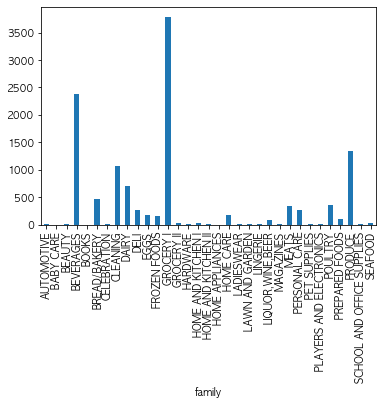

In [30]:
Train_data.groupby('family')['sales'].mean().plot(kind='bar')
plt.show()